In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
NODE_ID=25

In [3]:
from src.utils import get_target_microservice_id

get_target_microservice_id()

np.int64(25)

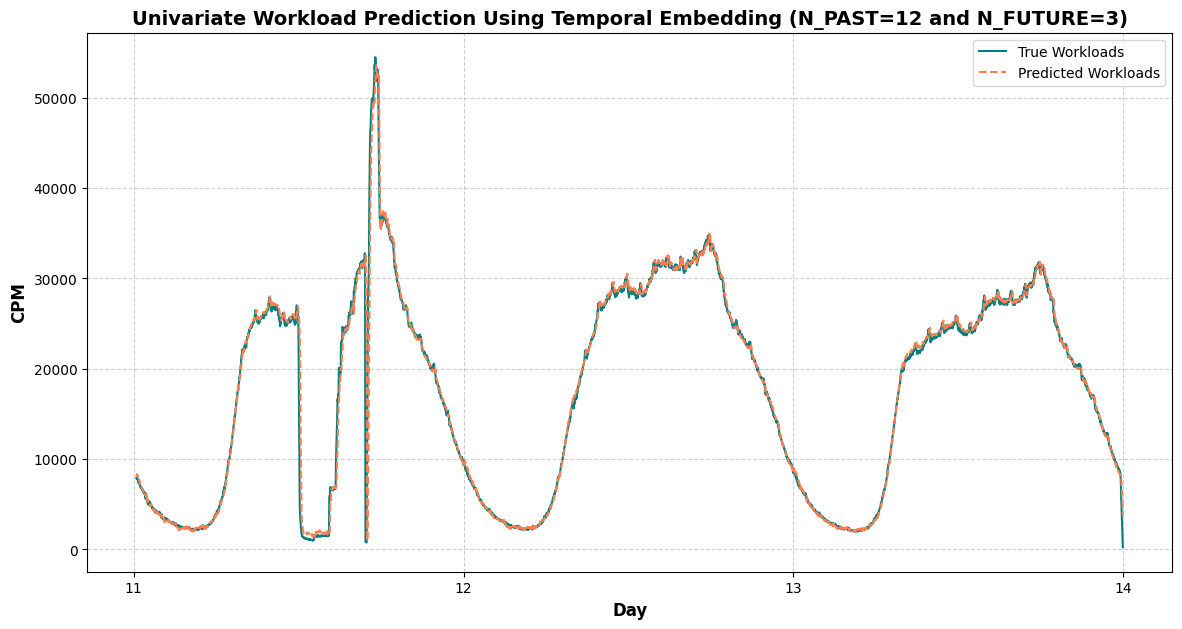

In [4]:
from src.plot import plot_pred_and_true_workloads

plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_with_embedding/results/informer_sl12_ll6_pl3_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Using Temporal Embedding (N_PAST=12 and N_FUTURE=3)',
    f'../plots/univariate_using_temporal_embedding_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

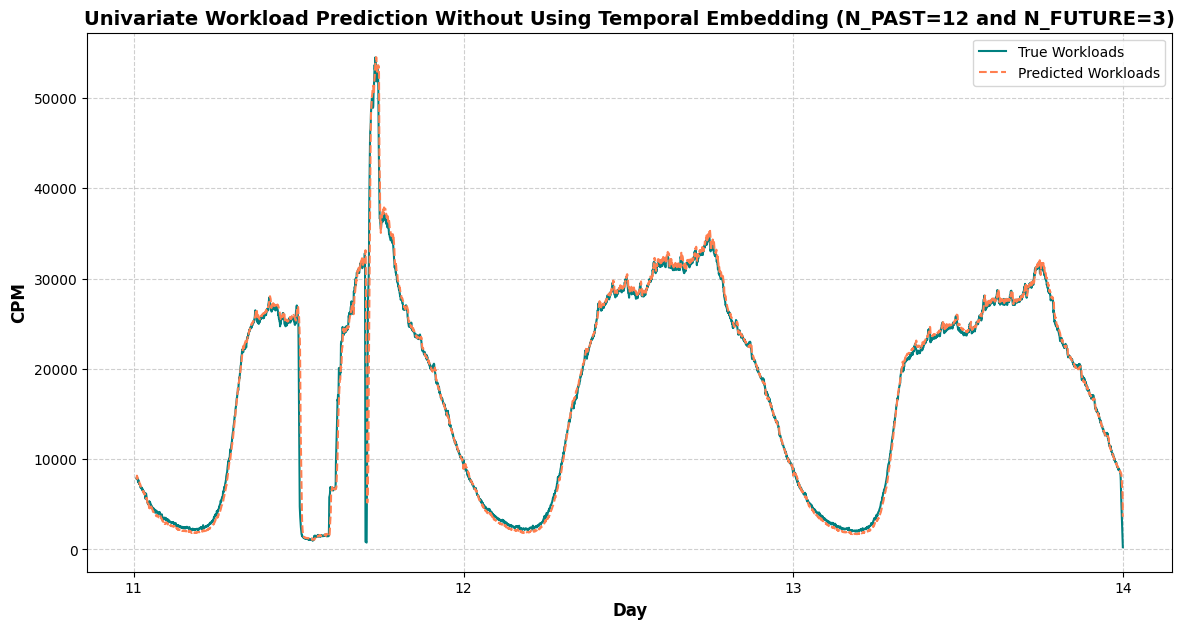

In [5]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_without_embedding/results/informer_sl12_ll6_pl3_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Without Using Temporal Embedding (N_PAST=12 and N_FUTURE=3)',
    f'../plots/univariate_without_using_temporal_embedding_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

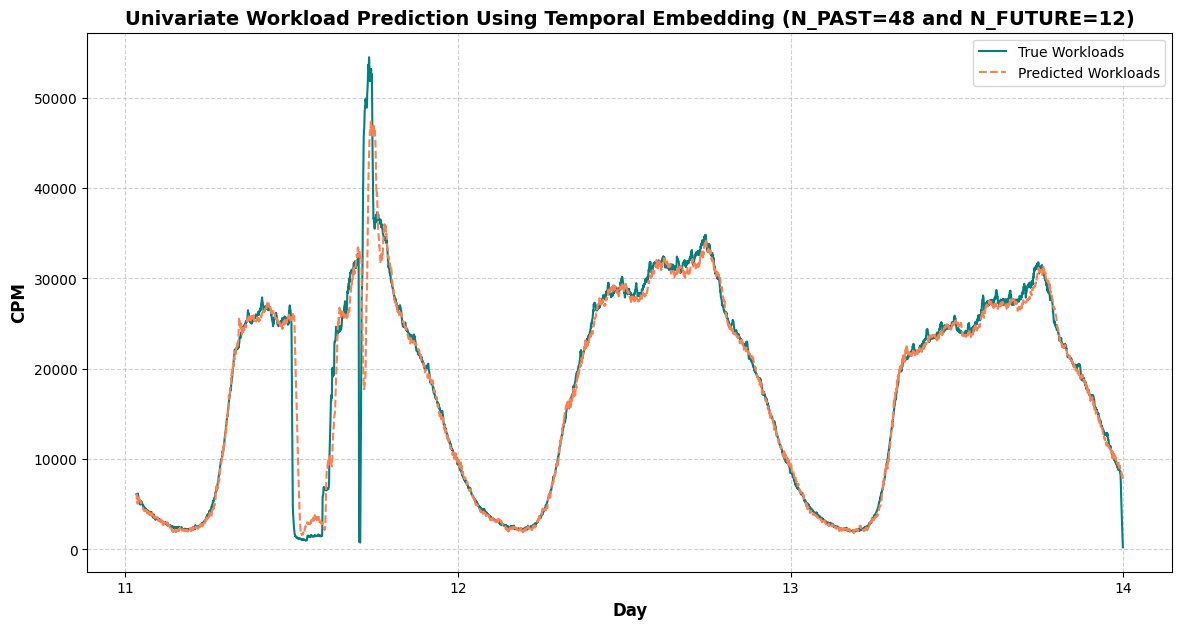

In [6]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_with_embedding_long_range_pred/results/informer_sl48_ll24_pl12_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Using Temporal Embedding (N_PAST=48 and N_FUTURE=12)',
    f'../plots/univariate_long_term_using_temporal_embedding_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

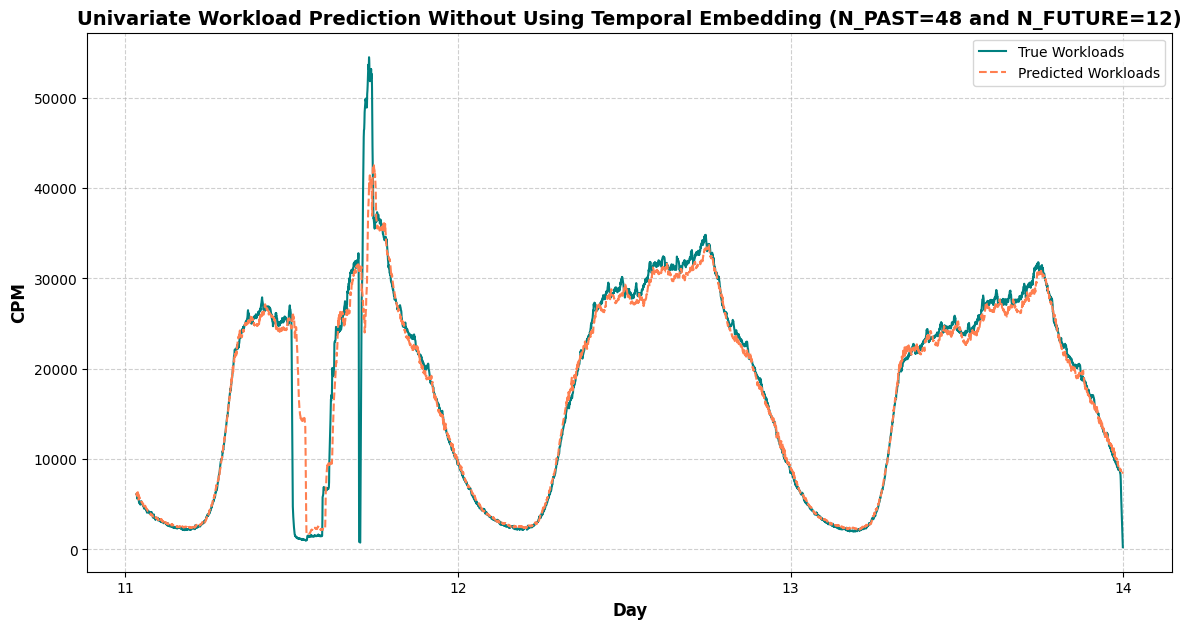

In [7]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_without_embedding_long_range_pred/results/informer_sl48_ll24_pl12_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Without Using Temporal Embedding (N_PAST=48 and N_FUTURE=12)',
    f'../plots/univariate_long_term_without_using_temporal_embedding_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

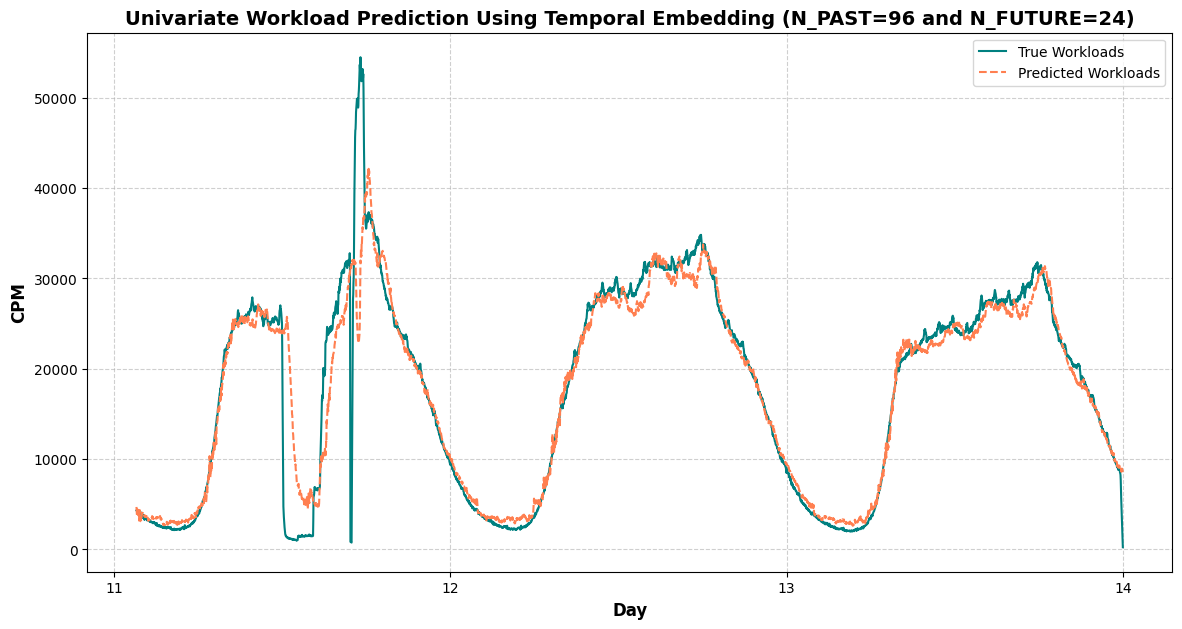

In [8]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_with_embedding_long_range_pred_24/results/informer_sl96_ll48_pl24_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Using Temporal Embedding (N_PAST=96 and N_FUTURE=24)',
    f'../plots/univariate_long_term_using_temporal_embedding_24_minutes_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

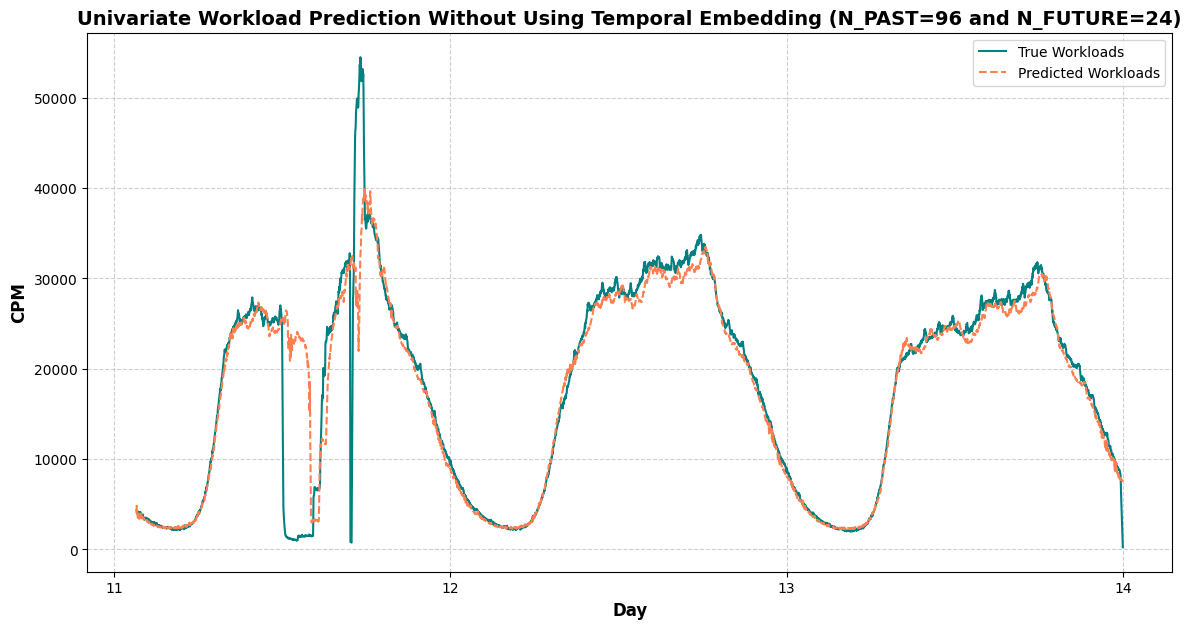

In [9]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_without_embedding_long_range_pred_24/results/informer_sl96_ll48_pl24_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Without Using Temporal Embedding (N_PAST=96 and N_FUTURE=24)',
    f'../plots/univariate_long_term_without_using_temporal_embedding_24_minutes_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

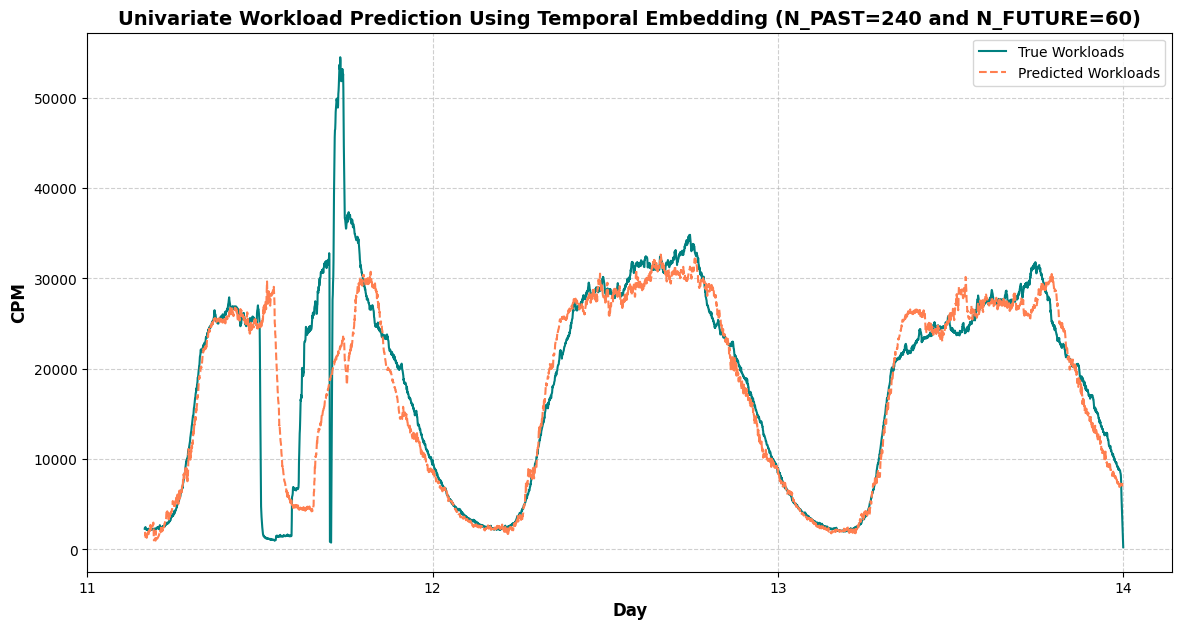

In [10]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_with_embedding_long_range_pred_60/results/informer_sl240_ll120_pl60_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Using Temporal Embedding (N_PAST=240 and N_FUTURE=60)',
    f'../plots/univariate_long_term_using_temporal_embedding_60_minutes_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

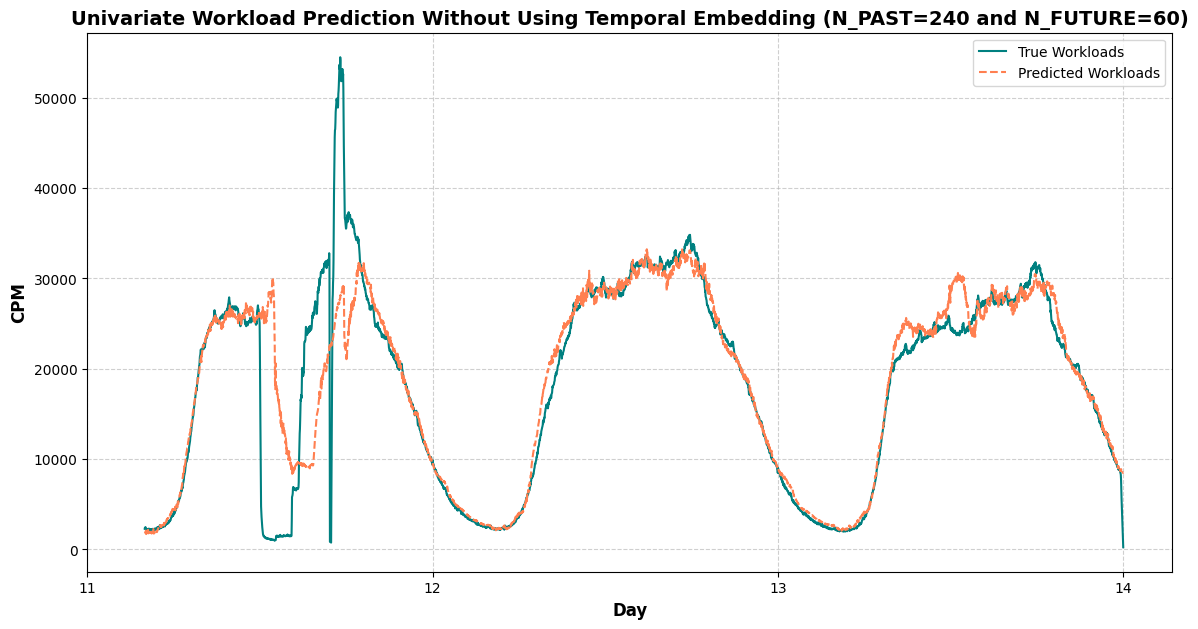

In [11]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_without_embedding_long_range_pred_60/results/informer_sl240_ll120_pl60_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Without Using Temporal Embedding (N_PAST=240 and N_FUTURE=60)',
    f'../plots/univariate_long_term_without_using_temporal_embedding_60_minutes_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

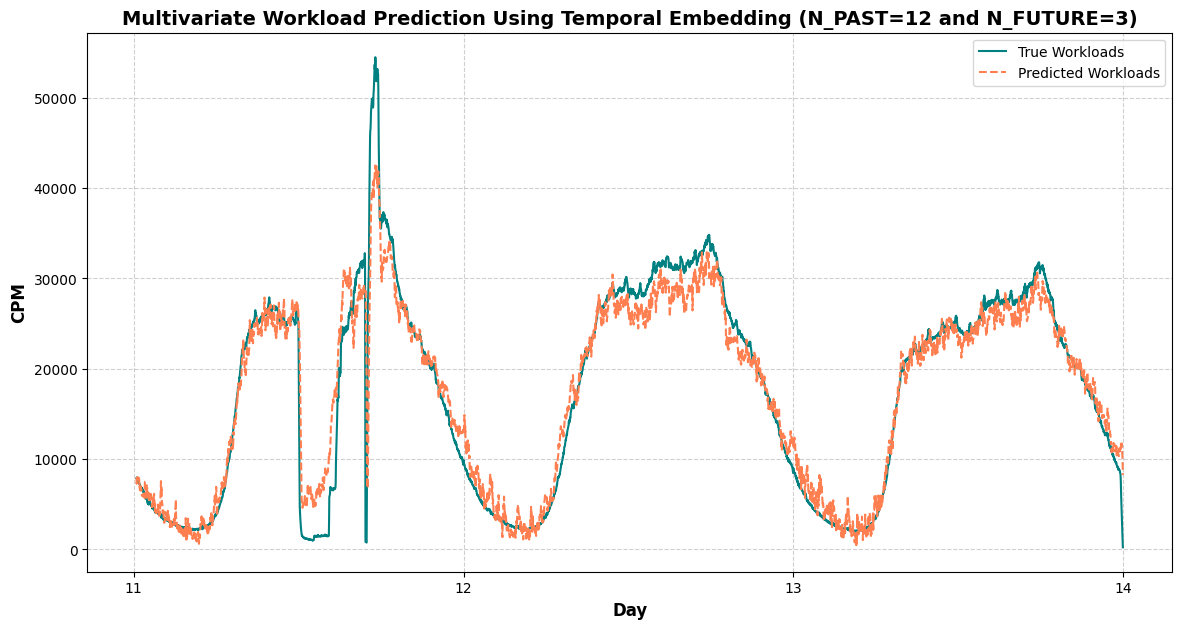

In [12]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/multivariate_with_embedding/results/informer_sl12_ll6_pl3_dm2048_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Multivariate Workload Prediction Using Temporal Embedding (N_PAST=12 and N_FUTURE=3)',
    f'../plots/multivariate_using_temporal_embedding_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

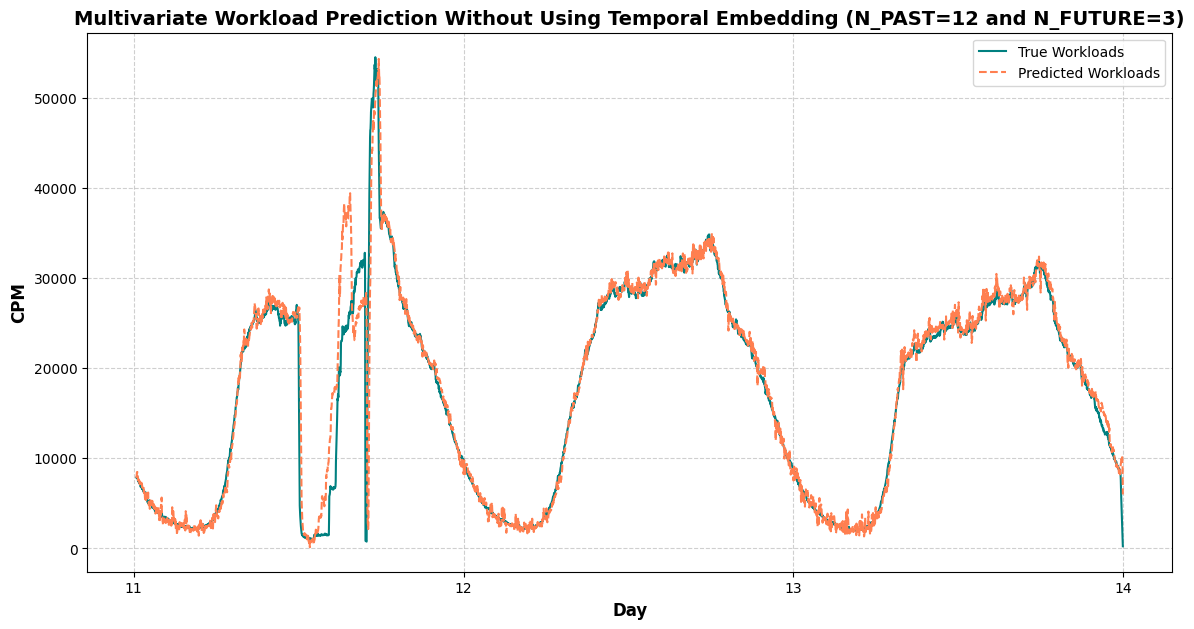

In [13]:
plot_pred_and_true_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/multivariate_without_embedding/results/informer_sl12_ll6_pl3_dm2048_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Multivariate Workload Prediction Without Using Temporal Embedding (N_PAST=12 and N_FUTURE=3)',
    f'../plots/multivariate_without_using_temporal_embedding_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

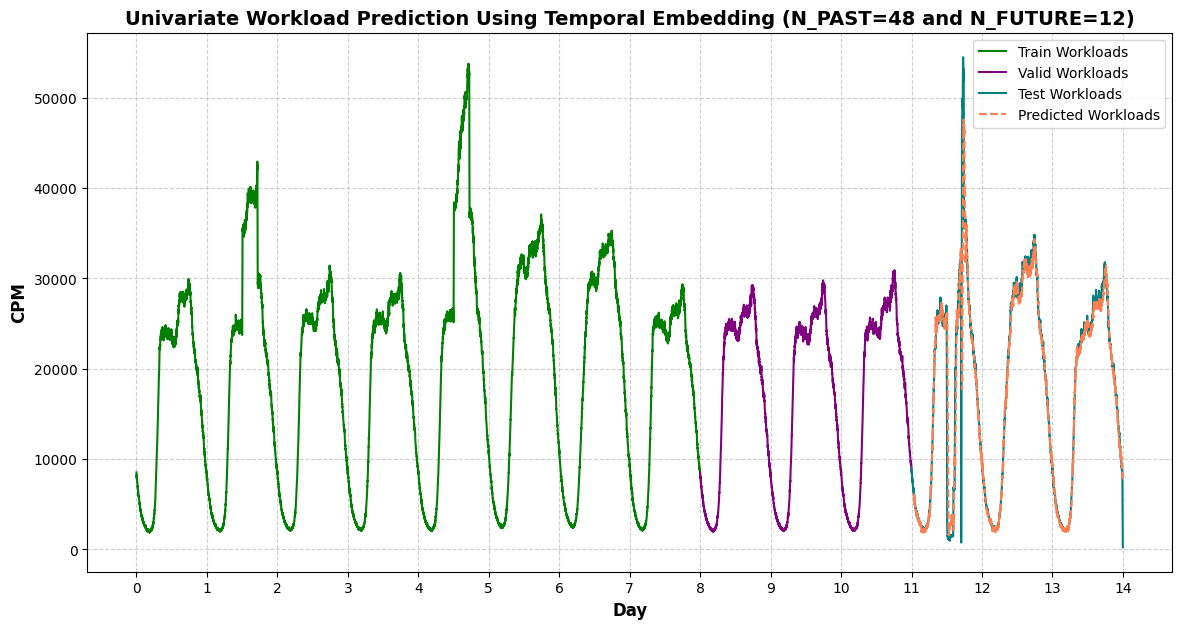

In [14]:
from src.plot import plot_full_workloads

plot_full_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_with_embedding_long_range_pred/results/informer_sl48_ll24_pl12_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Using Temporal Embedding (N_PAST=48 and N_FUTURE=12)',
    f'../plots/univariate_long_term_using_temporal_embedding_FULL_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)

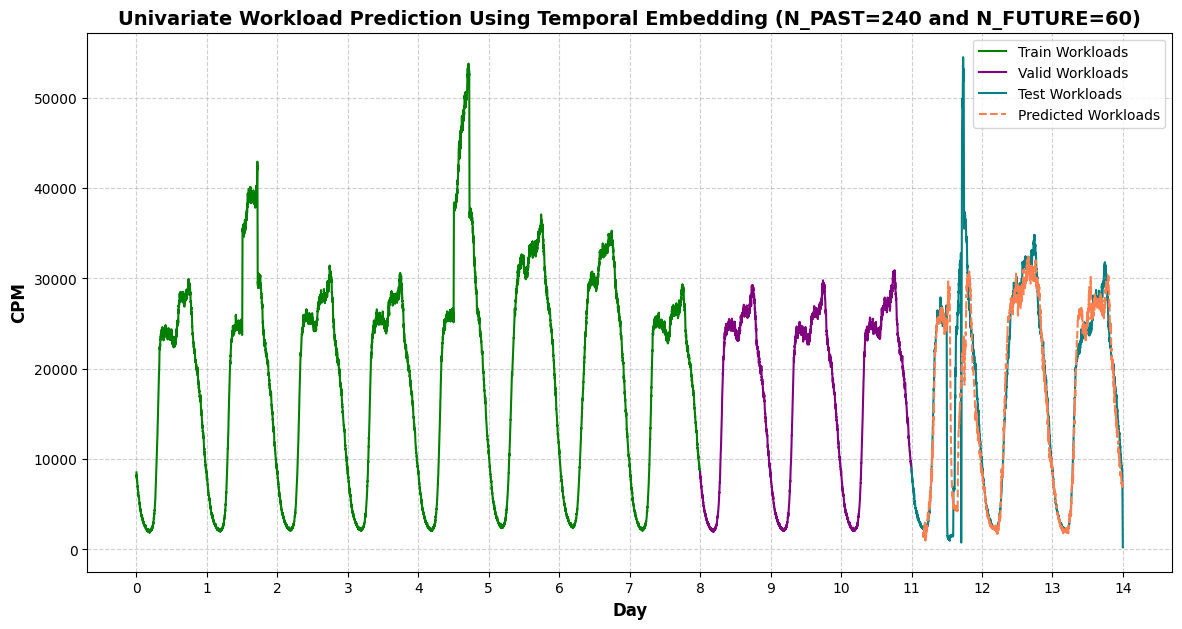

In [15]:
plot_full_workloads(
    f'/Users/ashfaq/Documents/alibaba_gnn_results/workload_prediction_results_{NODE_ID}/univariate_with_embedding_long_range_pred_60/results/informer_sl240_ll120_pl60_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue/real_prediction.npy',
    'Univariate Workload Prediction Using Temporal Embedding (N_PAST=240 and N_FUTURE=60)',
    f'../plots/univariate_long_term_using_temporal_embedding_60_minutes_FULL_{NODE_ID}.png',
    take_first=False,
    microservice_id=NODE_ID
)